## Overview
A startup company is focusing on various ML solutions for European banking market.

*We want to develop a ML system leveraging call center data to improve the success rate for calls made to customers for the client's products -  
high success rate + interpretability for our clients to make informed decisions.*

**Recent survey data subset:**  

age = age of customer (numeric)  
job = type of job (categorical)  
marital = marital status (categorical)  
education = max education (categorical)  
default = has credit in default? (binary)  
balance = average yearly balance, in euros (numeric)  
housing = has a housing loan? (binary)  
loan = has personal loan? (binary)  
contact = contact communication type (categorical)  
day = last contact day of the month (numeric)  
month = last contact month of year (categorical)  
duration = last contact duration, in seconds (numeric)  
campaign = number of contacts performed during this campaign and for this client (numeric, includes last contact)  

y = has the client subscribed to a term deposit? (binary)

**Goals:**  

*Predict (e.g., >81% accuracy) if a customer will subscribe.* 

*Segment customers based on investment likelihood.*

*Determine features that most determine investment.*  

## Imports

In [47]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful
import pickle
from sklearn.preprocessing import (LabelEncoder, OrdinalEncoder)
from collections import defaultdict

# Machine learning algorithms
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)
import lightgbm as lgb
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
import scipy.cluster.hierarchy as sch

# For hyperparameter tuning
from sklearn.model_selection import (train_test_split, cross_val_score, KFold)
from yellowbrick.model_selection import validation_curve

# For evaluation
from sklearn.metrics import (confusion_matrix, classification_report, f1_score)
from sklearn.metrics import (roc_curve, auc)

# For quickly testing models
from pycaret.classification import *

# Statistics
from scipy import stats
from scipy.stats import yeojohnson

# Feature inspection
import shap

## Load data and clean

In [48]:
df = pd.read_csv('files/marketing.csv')
print('Shape is', df.shape)
df.head(3)

Shape is (40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no


In [49]:
# Are there any nans in the 40000 rows, and what are dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [50]:
# What are the basic statistics for each feature?
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,40000.0,NaN,NaN,NaN,40.5446,9.641776,19.0,33.0,39.0,48.0,95.0
job,40000,12,blue-collar,9383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,40000,3,married,24386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,40000,4,secondary,20993,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,40000,2,no,39191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,40000.0,NaN,NaN,NaN,1274.27755,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
housing,40000,2,yes,24031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,40000,2,no,33070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,40000,3,cellular,24914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,40000.0,NaN,NaN,NaN,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0


Most customers have blue collar jobs, are married, finished secondary school, and presently have a housing loan.

## Train-test split

In [51]:
# Set random seed for randomness, here on out
ranseed = 99
np.random.seed(ranseed)

In [52]:
# Since the dataset is clean, we will split it now to avoid data leakage.

# Split
y_raw = df['y'].to_numpy()
X_raw = df.iloc[:,:-1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_raw, 
                                                    y_raw, 
                                                    test_size=0.25, 
                                                    random_state=ranseed, 
                                                    stratify=y_raw)

# Build dataframes from training and test sets
df_raw_tr = pd.DataFrame(X_train, columns=df.columns[:-1])
df_raw_tr['y'] = y_train
df_raw_te = pd.DataFrame(X_test, columns=df.columns[:-1])
df_raw_te['y'] = y_test

# Convert the originally numerical back to number form
nums = list(df.select_dtypes('number').columns)
for n in nums:
    df_raw_tr[n] = df_raw_tr[n].astype('int64')
    df_raw_te[n] = df_raw_te[n].astype('int64')

# Convert binary variables to numbers
binary = ['default', 'housing', 'loan', 'y']
for b in binary:
    df_raw_tr[b] = df_raw_tr[b].map(dict(yes=1, no=0))
    df_raw_te[b] = df_raw_te[b].map(dict(yes=1, no=0))

print('Training set info:\n')
print(df_raw_tr.info())

print(f'\nShape of test set is {df_raw_te.shape}\n')

df_raw_tr.to_csv('files/rawtrainingset.csv', index=False)
df_raw_te.to_csv('files/rawtestset.csv', index=False)

Training set info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        30000 non-null  int64 
 1   job        30000 non-null  object
 2   marital    30000 non-null  object
 3   education  30000 non-null  object
 4   default    30000 non-null  int64 
 5   balance    30000 non-null  int64 
 6   housing    30000 non-null  int64 
 7   loan       30000 non-null  int64 
 8   contact    30000 non-null  object
 9   day        30000 non-null  int64 
 10  month      30000 non-null  object
 11  duration   30000 non-null  int64 
 12  campaign   30000 non-null  int64 
 13  y          30000 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 3.2+ MB
None

Shape of test set is (10000, 14)



From here on out we will explore the training set and make any necessary transformations based on it alone. The test set will undergo the same transformations, but the choice of those transformations is not informed by knowledge of the test set.

## Data exploration

#### Numerical data

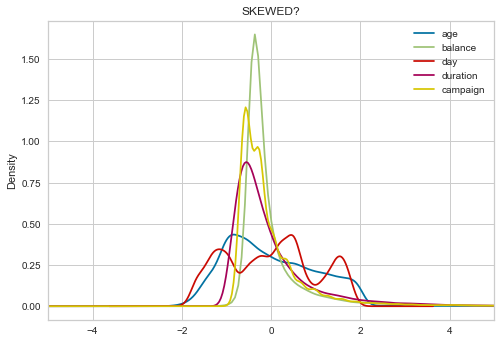

In [53]:
# Examine distributions for numerical data

# Numerical data
dfnum = df_raw_tr[nums]

# Normalize (standard scaler) so we can view all data (except y) on same graph
for c in dfnum.columns:
    dfnum[c] = (dfnum[c] - dfnum[c].mean())/dfnum[c].std()

# Plot
ax = dfnum.plot(kind='kde', title='SKEWED?')
ax.set_xlim(-5, 5)
plt.show()

In [54]:
# Calculation of feature skewness

skew_vals = dfnum.skew()
skew_vals.sort_values(ascending = False)

balance     8.853252
campaign    4.766960
duration    3.235284
age         0.441831
day         0.070863
dtype: float64

The balance, campaign, and duration are significantly skewed to the right. The age is also positively skewed, slightly. The day is roughly normal.

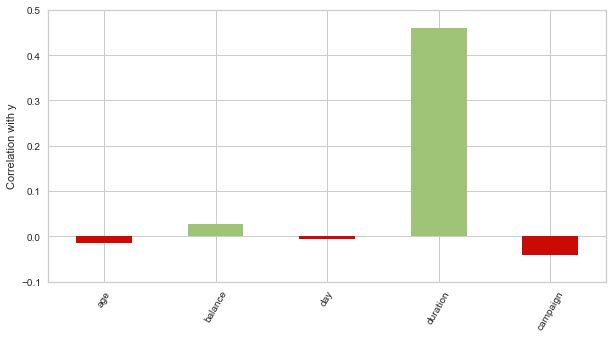

In [55]:
# Correlation matrix
dfnum['y'] = df_raw_tr['y']
corr = dfnum.corr()

# Plot correlations
plt.figure(figsize=(10,5))
corr['y'].drop('y').plot(kind='bar', 
                         color=(corr['y'] > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(corr.index)-1), labels=corr.drop('y').index)
plt.ylabel('Correlation with y')
plt.ylim(-0.1, 0.5)
plt.show()

The weakest correlation with y is the day of the month. Other weakly linked features are age, balance, and campaign. However, y could have a nonlinear dependence on any of these, which is not well-represented by correlation. We will bin each of these features to make them categorical, and in some cases onehot encode them. In doing we can examine if any particular subset of these features correlates well with y. This also avoids most issues with skewness.

Below is a histogram for the features from which we choose a binning procedure.

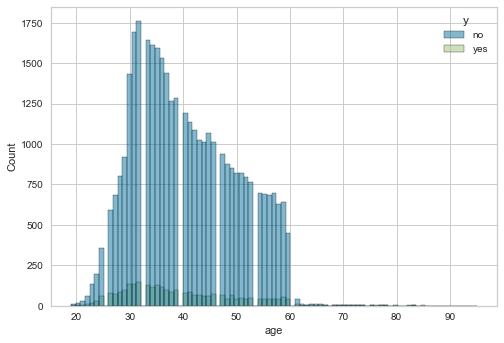

In [56]:
sns.histplot(data=df, x=nums[0], hue='y')
plt.show()

The distributions for yes/no aren't too different. We will bin every 5 years, with <20 and >60 as separate categories.

In [57]:
# Create bins and labels for increments of 5 years
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, df['age'].max()]
labels = ['20_under', '21_25years', '26_30years', '31_35years', '36_40years', 
          '41_45years', '46_50years', '51_55years', '56_60years', '61_over']

# Binning
df_raw_tr['age'] = pd.cut(df_raw_tr['age'], bins=bins, labels=labels, include_lowest=True)
df_raw_te['age'] = pd.cut(df_raw_te['age'], bins=bins, labels=labels, include_lowest=True)

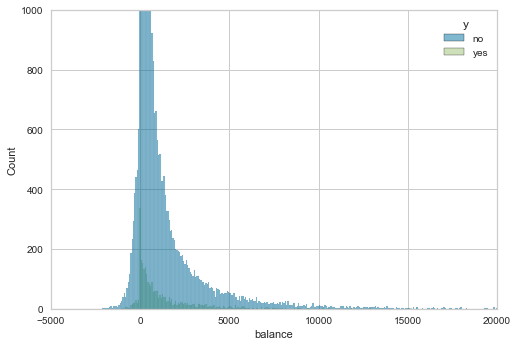

In [58]:
# Zoomed in for this one
sns.histplot(data=df, x=nums[1], hue='y')
plt.xlim(-5000, 20000)
plt.ylim(0, 1000)
plt.show()

Again, distributions aren't too different for the classes. We will use the training set quantiles to bin these.

In [59]:
# Binning, returning the quantile bins from training set
df_raw_tr['balance'], bins = pd.qcut(df_raw_tr['balance'], q=5, precision=0, retbins=True)

# Binning test set with training quantiles (NOTE: different interval for 1st bin taken care of by OrdinalEncoder)
df_raw_te['balance'] = pd.cut(df_raw_te['balance'], bins=bins, include_lowest=False)

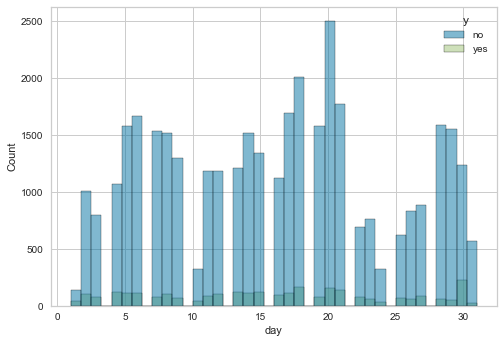

In [60]:
sns.histplot(data=df, x=nums[2], hue='y')
plt.show()

There are some differences between classes. It looks like the 30th is the best day for investing. This may or may not be an artifact. We will keep this feature as is, and remove it if it contributes little to the model.

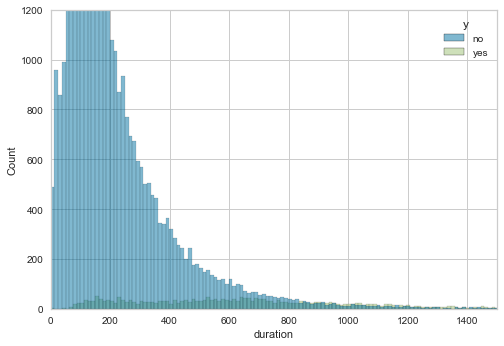

In [61]:
# Zoomed in for this one
sns.histplot(data=df, x=nums[3], hue='y')
plt.xlim(0, 1500)
plt.ylim(0, 1200)
plt.show()

There is a clear difference between classes here. We will use 120 (2min) as the bin size, with an over 900 (15min) category as well.

In [62]:
# Create bins and labels for increments of 2 minutes
bins = [120 * x for x in range(8)] + [df['duration'].max()]
labels = ['00-02min', '02-04min', '04-06min', '06-08min', '08-10min', 
          '10-12min', '12-14min', '15-plusmin']

# Binning
df_raw_tr['duration'] = pd.cut(df_raw_tr['duration'], bins=bins, labels=labels, include_lowest=True)
df_raw_te['duration'] = pd.cut(df_raw_te['duration'], bins=bins, labels=labels, include_lowest=True)

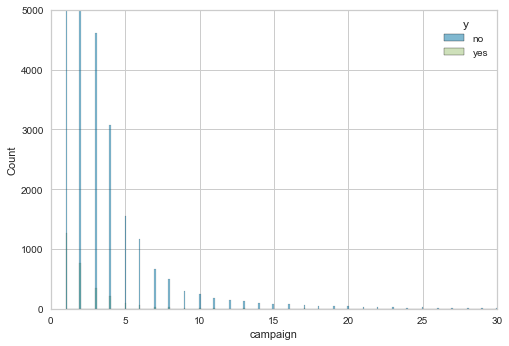

In [63]:
# Zoomed in for this one
sns.histplot(data=df, x=nums[4], hue='y')
plt.xlim(0, 30)
plt.ylim(0, 5000)
plt.show()

We will lump all the values over 10 together.

In [64]:
# Create bins and labels for increments of 2 minutes
bins = [x for x in range(11)] + [df['campaign'].max()]
labels = [str(x) for x in range(10)] + ['over10']

# Binning
df_raw_tr['campaign'] = pd.cut(df_raw_tr['campaign'], bins=bins, labels=labels, include_lowest=True)
df_raw_te['campaign'] = pd.cut(df_raw_te['campaign'], bins=bins, labels=labels, include_lowest=True)

#### Categorical data

We have categorical data from the binning we performed above, along with some of the original features, which we will now look at.

In [65]:
df_raw_tr.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,41_45years,technician,divorced,secondary,0,"(-8020.0, 11.0]",0,0,cellular,12,aug,00-02min,1,0


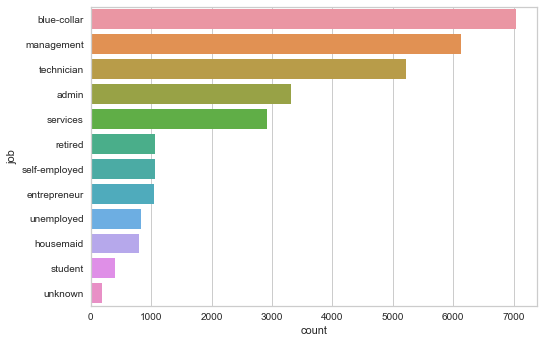

In [66]:
# Start with job
sns.countplot(data=df_raw_tr, y='job', order=df_raw_tr['job'].value_counts().index)
plt.show()

We can combine some overlapping job categories.

In [67]:
df_raw_tr.loc[df_raw_tr.job == 'housemaid', 'job'] = 'services'
df_raw_tr.loc[df_raw_tr.job == 'entrepreneur', 'job'] = 'self-employed'
df_raw_tr.loc[df_raw_tr.job == 'retired', 'job'] = 'unemployed'
df_raw_tr.loc[df_raw_tr.job == 'technician', 'job'] = 'blue-collar'

df_raw_te.loc[df_raw_te.job == 'housemaid', 'job'] = 'services'
df_raw_te.loc[df_raw_te.job == 'entrepreneur', 'job'] = 'self-employed'
df_raw_te.loc[df_raw_te.job == 'retired', 'job'] = 'unemployed'
df_raw_te.loc[df_raw_te.job == 'technician', 'job'] = 'blue-collar'

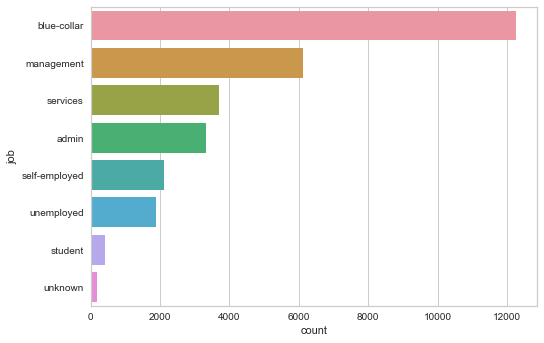

In [68]:
# Replot job
sns.countplot(data=df_raw_tr, y='job', order=df_raw_tr['job'].value_counts().index)
plt.show()

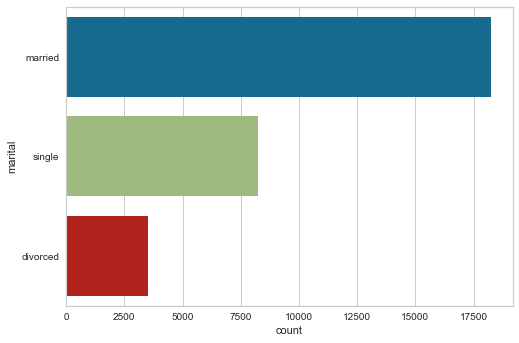

In [69]:
# Marital (no need to adjust)
sns.countplot(data=df_raw_tr, y='marital', order=df_raw_tr['marital'].value_counts().index)
plt.show()

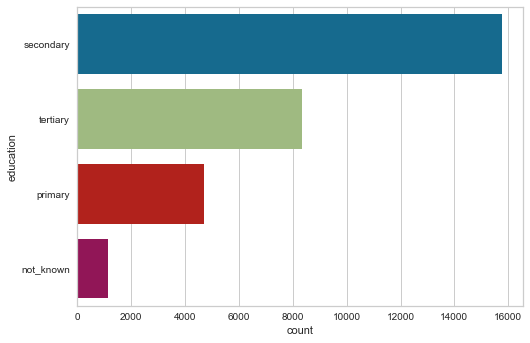

In [70]:
# Education (no need to adjust, except that we will change label for 'unknown' to give it 0 ordinality)
df_raw_tr.loc[df_raw_tr.education == 'unknown', 'education'] = 'not_known'
df_raw_te.loc[df_raw_te.education == 'unknown', 'education'] = 'not_known'

sns.countplot(data=df_raw_tr, y='education', order=df_raw_tr['education'].value_counts().index)
plt.show()

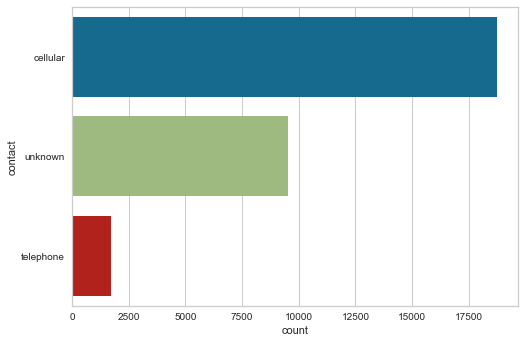

In [71]:
# Contact (no need to adjust)
sns.countplot(data=df_raw_tr, y='contact', order=df_raw_tr['contact'].value_counts().index)
plt.show()

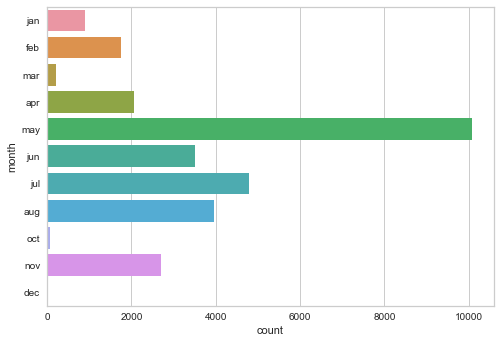

In [72]:
# Month (no need to adjust...no data for September)
sns.countplot(data=df_raw_tr, y='month', order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                               'jul', 'aug', 'oct', 'nov', 'dec'])
plt.show()

We can now encode the categorical features.

In [73]:
# New dataframes
df_enc_tr = df_raw_tr.copy()
df_enc_te = df_raw_te.copy()

# Onehot encode some variables
oh_list = ['job', 'marital', 'contact']
df_enc_tr = pd.get_dummies(df_enc_tr, columns=oh_list, drop_first = False)
df_enc_te = pd.get_dummies(df_enc_te, columns=oh_list, drop_first = False)

# Label encode some variables (where categories are numbered in alphabetical/numerical order)
le_list = ['month']
le = LabelEncoder()
d = defaultdict(LabelEncoder)
df_enc_tr[le_list] = df_raw_tr[le_list].apply(lambda x: d[x.name].fit_transform(x))
df_enc_te[le_list] = df_raw_te[le_list].apply(lambda x: d[x.name].fit_transform(x))
# Code snippet for inverse transform and labels...
# Inverse the encoded
# df_enc_tr[le_list].apply(lambda x: d[x.name].inverse_transform(x))
# Using the dictionary to label future data
# df_enc_tr[le_list].apply(lambda x: d[x.name].transform(x))

# Ordinal encode some variables (where categories are numbered in alphabetical order)
oe_list = ['age', 'education', 'balance', 'duration', 'campaign']
oe = OrdinalEncoder()
d_o = defaultdict(OrdinalEncoder)
df_enc_tr[oe_list] = oe.fit_transform(df_enc_tr[oe_list])
df_enc_te[oe_list] = oe.fit_transform(df_enc_te[oe_list])

# Check ordinality of some encodings
print(oe.categories_,'\n')

# Make y last variable for convenience
ytr = df_enc_tr.pop('y')
df_enc_tr['y'] = ytr
yte = df_enc_te.pop('y')
df_enc_te['y'] = yte

df_enc_tr.head(2)

[array(['20_under', '21_25years', '26_30years', '31_35years', '36_40years',
       '41_45years', '46_50years', '51_55years', '56_60years', '61_over'],
      dtype=object), array(['not_known', 'primary', 'secondary', 'tertiary'], dtype=object), array([Interval(-8019.0, 11.0, closed='right'),
       Interval(11.0, 242.0, closed='right'),
       Interval(242.0, 644.0, closed='right'),
       Interval(644.0, 1697.0, closed='right'),
       Interval(1697.0, 102127.0, closed='right')], dtype=object), array(['00-02min', '02-04min', '04-06min', '06-08min', '08-10min',
       '10-12min', '12-14min', '15-plusmin'], dtype=object), array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'over10'],
      dtype=object)] 



,age,education,default,balance,housing,loan,day,month,duration,campaign,...,job_student,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,y
0,5.0,2.0,0,0.0,0,0,12,1,0.0,1.0,...,0,0,0,1,0,0,1,0,0,0
1,5.0,0.0,0,2.0,0,0,4,3,0.0,3.0,...,0,0,0,0,1,0,0,1,0,0


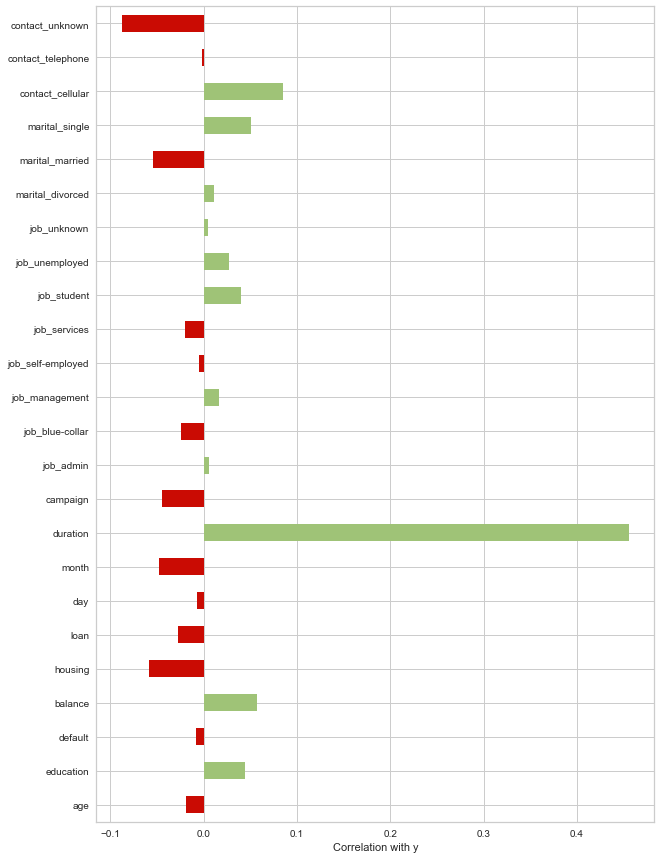

In [74]:
# Create correlation matrix
corr = df_enc_tr.corr()

# Series of interest
s = corr['y'].drop('y')

# Plot correlations (zoomed in)
plt.figure(figsize=(10,15))
s.plot(kind='barh', color=(s > 0).map({True: 'g', False: 'r'}), )
plt.yticks(np.arange(len(s)), labels=s.index)
plt.xlabel('Correlation with y')
# plt.xlim(-0.1, 0.1)
plt.show()

In [75]:
print(f'There are {(np.abs(s) < .01).sum()} features out of {len(s)} with correlation coefficient, r < |0.01|.')

s[(np.abs(s) < .01)]

There are 6 features out of 24 with correlation coefficient, r < |0.01|.


default             -0.008272
day                 -0.006673
job_admin            0.005620
job_self-employed   -0.004522
job_unknown          0.005078
contact_telephone   -0.001282
Name: y, dtype: float64

Clearly, certain features (e.g., 'duration') show much stronger correlations than others (e.g., 'contact_telephone'). 

We will remove 5 of the 6, keeping 'day' since it could have a nonlinear relationship with y.

## Feature Selection

In [76]:
# Remove variables with low correlation coefficients
cols = list(s[np.abs(s) < .01].index)
cols.remove('day')
df_enc_tr.drop(columns=cols, inplace=True)
df_enc_te.drop(columns=cols, inplace=True)

df_enc_tr.head(1)

,age,education,balance,housing,loan,day,month,duration,campaign,job_blue-collar,job_management,job_services,job_student,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_unknown,y
0,5.0,2.0,0.0,0,0,12,1,0.0,1.0,1,0,0,0,0,1,0,0,1,0,0


In [77]:
# Save encoded train and test sets
df_enc_tr.to_csv('files/trainingset_enc.csv', index=False)
df_enc_te.to_csv('files/testset_enc.csv', index=False)

df_enc_tr.shape

(30000, 20)

In [78]:
# Reload encoded train and test sets
train = pd.read_csv('files/trainingset_enc.csv')
test = pd.read_csv('files/testset_enc.csv')

train.shape

(30000, 20)

Our final dataset has 19 encoded, independent variables and 1 dependent variable.

## Model exploration

We will first use PyCaret on the imbalanced dataset.  

In [79]:
# Setup PyCaret and compare models for unbalanced dataset
s = setup(train, 
          target='y',
          fix_imbalance=True, 
          silent=True, 
          verbose=False)
top7 = compare_models(n_select=7)
best = automl(optimize='F1')
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9368,0.9465,0.4783,0.5796,0.5223,0.4889,0.4924,0.5590
rf,Random Forest Classifier,0.9349,0.9330,0.3784,0.5774,0.4557,0.4229,0.4343,1.4290
et,Extra Trees Classifier,0.9331,0.9277,0.4231,0.5493,0.4767,0.4418,0.4467,1.8420
dummy,Dummy Classifier,0.9275,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0400
gbc,Gradient Boosting Classifier,0.9264,0.9364,0.6196,0.4943,0.5496,0.5101,0.5141,2.8930
ada,Ada Boost Classifier,0.9172,0.9185,0.5867,0.4466,0.5067,0.4625,0.4679,0.8290
dt,Decision Tree Classifier,0.9119,0.6935,0.4382,0.4008,0.4183,0.3708,0.3714,0.1120
lda,Linear Discriminant Analysis,0.8686,0.9270,0.8482,0.3382,0.4834,0.4236,0.4829,0.1060
ridge,Ridge Classifier,0.8685,0.0000,0.8482,0.3381,0.4833,0.4235,0.4828,0.0430
lr,Logistic Regression,0.8658,0.9271,0.8581,0.3343,0.4810,0.4206,0.4827,1.8210


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8351, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


LGBM, RFC, and ETC are best. We will try fixing imbalance on our own and trying PyCaret again.

In [80]:
# Create 2, class-specific dataframes

df_invest = train[train['y'] == 1].reset_index(drop=True)
df_notinvest = train[train['y'] == 0].reset_index(drop=True)

print(f'In the training set, there are {len(df_invest)} investors and {len(df_notinvest)} that did not invest.')

In the training set, there are 2172 investors and 27828 that did not invest.


In [81]:
# Now we will randomly upsample to match the class sizes,
# and we will bootstrap by repeating the process 10 times with 10 different random states. 

for boot in range(10):
    df_invest_s = df_invest.sample(n=len(df_notinvest), replace=True, random_state=boot * 10)
    df_invest_s.to_csv(f'files/train_investorclass_boot{boot}.csv', index=False)

# Combine classes for just 1 (the latest) upsample to be tested with PyCaret

df_balanced = pd.concat([df_invest_s, df_notinvest], axis=0).reset_index(drop=True)
df_balanced.shape

(55656, 20)

In [82]:
# Setup PyCaret and compare models for large balanced dataset
s = setup(df_balanced, 
          target='y', 
          silent=True, 
          verbose=False)
top7 = compare_models(n_select=7)
best = automl(optimize='F1')
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9849,0.9998,0.9999,0.9708,0.9851,0.9698,0.9703,0.9190
rf,Random Forest Classifier,0.9748,0.9997,0.9999,0.9522,0.9755,0.9497,0.9509,0.8320
dt,Decision Tree Classifier,0.9721,0.9720,0.9997,0.9474,0.9728,0.9441,0.9456,0.0730
knn,K Neighbors Classifier,0.9381,0.9725,0.9958,0.8928,0.9415,0.8762,0.8821,0.5370
lightgbm,Light Gradient Boosting Machine,0.9233,0.9678,0.9645,0.8911,0.9263,0.8465,0.8494,0.2070
gbc,Gradient Boosting Classifier,0.8892,0.9473,0.9154,0.8699,0.8921,0.7784,0.7795,1.4440
ada,Ada Boost Classifier,0.8677,0.9319,0.8662,0.8688,0.8675,0.7353,0.7354,0.4940
lr,Logistic Regression,0.8658,0.9312,0.8678,0.8645,0.8661,0.7317,0.7317,1.3670
ridge,Ridge Classifier,0.8620,0.0000,0.8496,0.8714,0.8603,0.7241,0.7243,0.0260
lda,Linear Discriminant Analysis,0.8620,0.9309,0.8496,0.8713,0.8603,0.7240,0.7243,0.0860


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1156, verbose=0,
                     warm_start=False)


Similar classifiers are at the top for the balanced dataset. We will explore the Extra Trees, Random Forest, Light GBM, and K Neighbors classifiers, focusing on just a few of the key hyperparameters.

In [83]:
# Define dataset
Xcv = df_balanced.iloc[:,:-1].to_numpy()
ycv = df_balanced['y'].to_numpy()

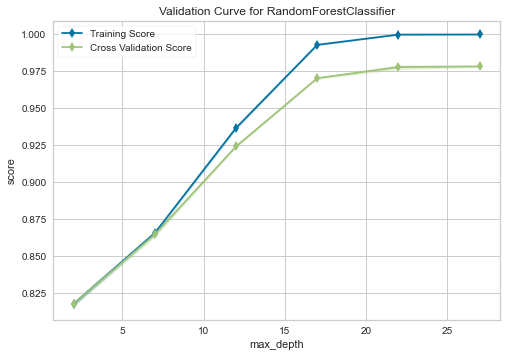

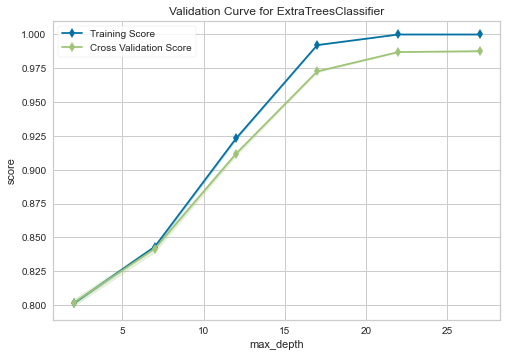

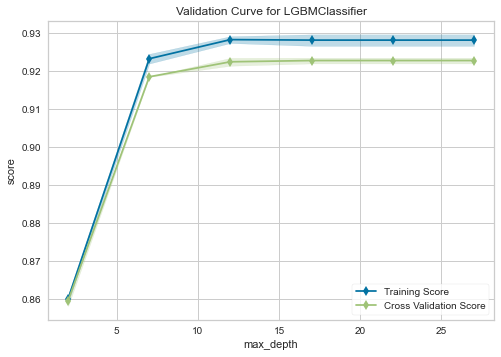

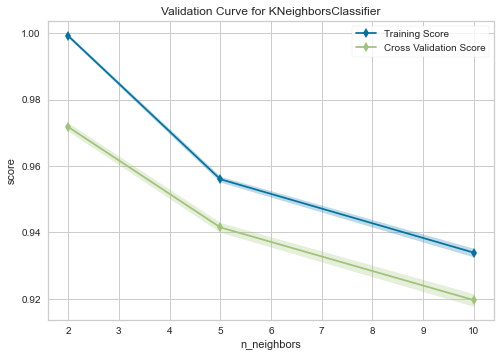

In [84]:
# Plot the validation curves for max_depth (trees) and n_neighbors (knn)

rfc = RandomForestClassifier(random_state=ranseed)
viz = validation_curve(rfc, Xcv, ycv, 
                       param_name='max_depth', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

etc = ExtraTreesClassifier(random_state=ranseed)
viz = validation_curve(etc, Xcv, ycv, 
                       param_name='max_depth', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

lgbm = lgb.LGBMClassifier(random_state=ranseed)
viz = validation_curve(lgbm, Xcv, ycv, 
                       param_name='max_depth', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

knn = KNeighborsClassifier()
viz = validation_curve(knn, Xcv, ycv, 
                       param_name='n_neighbors', n_jobs=-1,
                       param_range=[2, 5, 10], cv=3, 
                       scoring='f1_macro')

Best parameter values are not the defaults

In [85]:
# Set approximate best parameters from above
md_rf_et = 20
md_lgbm = 10
nn = 2

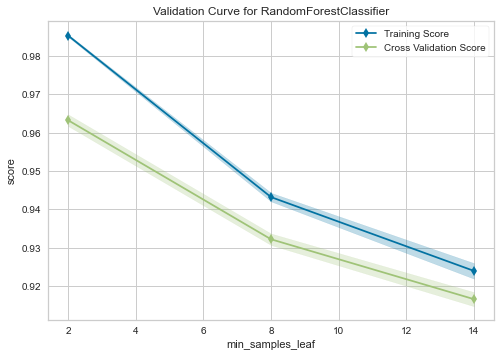

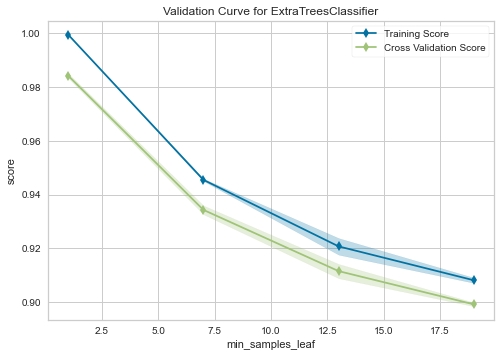

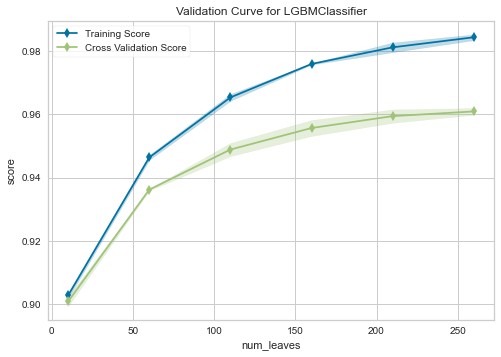

In [87]:
# Plot the validation curves for 'secondary' hyperparameters

rfc = RandomForestClassifier(max_depth=md_rf_et, random_state=ranseed)
viz = validation_curve(rfc, Xcv, ycv, 
                       param_name='min_samples_leaf', n_jobs=-1,
                       param_range=np.arange(2, 20, 6), cv=3, 
                       scoring='f1_macro')

etc = ExtraTreesClassifier(max_depth=md_rf_et, random_state=ranseed)
viz = validation_curve(etc, Xcv, ycv, 
                       param_name='min_samples_leaf', n_jobs=-1,
                       param_range=np.arange(1, 20, 6), cv=3, 
                       scoring='f1_macro')

lgbm = lgb.LGBMClassifier(max_depth=md_lgbm, random_state=ranseed)
viz = validation_curve(lgbm, Xcv, ycv, 
                       param_name='num_leaves', n_jobs=-1,
                       param_range=np.arange(10, 300, 50), cv=3, 
                       scoring='f1_macro')

Default parameter values are best for RFC and ETC, but not LGBM.

In [88]:
# Set best (nondefault) parameters from above
nl = 250

All tuned classifiers yield f1 scores > 96%. Perhaps combining one or more tree-based models with the very different K Neighbors in a Voting Classifier will work well.

## Modeling

We will cross validate each model for all 10 bootstrapped training sets.

In [89]:
kfold = KFold(n_splits=5, shuffle=True, random_state=ranseed)

rfc_kf = RandomForestClassifier(max_depth=md_rf_et, random_state=ranseed)

# Acquire all average scores
rfc_mean_score = []
rfc_mean_std = []
for b in range(10):
    df_boot = pd.read_csv(f'files/train_investorclass_boot{b}.csv')
    df_boot_bal = pd.concat([df_boot, df_notinvest], axis=0).reset_index(drop=True)
    Xcv = df_boot_bal.iloc[:,:-1].to_numpy()
    ycv = df_boot_bal['y'].to_numpy()
    
    rfc_result = cross_val_score(estimator=rfc_kf, 
                             X=Xcv, 
                             y=ycv, 
                             cv=kfold, 
                             scoring='f1_macro')
    rfc_mean_score.append(100*np.mean(rfc_result))
    rfc_mean_std.append(100*np.std(rfc_result))
    
print('The average macro f1 during 5-fold cross-validation of all bootstraps for Random Forest is '
      f'{np.mean(rfc_mean_score):.4}% +/- {np.std(rfc_mean_score):.2}%.')

# Save model
rfc_file = 'files/rfc.sav'
pickle.dump(rfc_kf, open(rfc_file, 'wb'))

The average macro f1 during 5-fold cross-validation of all bootstraps for Random Forest is 97.93% +/- 0.023%.


In [90]:
etc_kf = ExtraTreesClassifier(max_depth=md_rf_et, random_state=ranseed)

# Acquire all average scores
etc_mean_score = []
etc_mean_std = []
for b in range(10):
    df_boot = pd.read_csv(f'files/train_investorclass_boot{b}.csv')
    df_boot_bal = pd.concat([df_boot, df_notinvest], axis=0).reset_index(drop=True)
    Xcv = df_boot_bal.iloc[:,:-1].to_numpy()
    ycv = df_boot_bal['y'].to_numpy()
    
    etc_result = cross_val_score(estimator=etc_kf, 
                             X=Xcv, 
                             y=ycv, 
                             cv=kfold, 
                             scoring='f1_macro')

    etc_mean_score.append(100*np.mean(etc_result))
    etc_mean_std.append(100*np.std(etc_result))
    
print('The average macro f1 during 5-fold cross-validation of all bootstraps for Extra Trees is '
      f'{np.mean(etc_mean_score):.4}% +/- {np.std(etc_mean_score):.2}%.')

# Save model
etc_file = 'files/etc.sav'
pickle.dump(etc_kf, open(etc_file, 'wb'))

The average macro f1 during 5-fold cross-validation of all bootstraps for Extra Trees is 98.62% +/- 0.026%.


In [91]:
lgbm_kf = lgb.LGBMClassifier(max_depth=md_lgbm, num_leaves=nl, random_state=ranseed)

# Acquire all average scores
lgbm_mean_score = []
lgbm_mean_std = []
for b in range(10):
    df_boot = pd.read_csv(f'files/train_investorclass_boot{b}.csv')
    df_boot_bal = pd.concat([df_boot, df_notinvest], axis=0).reset_index(drop=True)
    Xcv = df_boot_bal.iloc[:,:-1].to_numpy()
    ycv = df_boot_bal['y'].to_numpy()
    
    lgbm_result = cross_val_score(estimator=lgbm_kf, 
                             X=Xcv, 
                             y=ycv, 
                             cv=kfold, 
                             scoring='f1_macro')

    lgbm_mean_score.append(100*np.mean(lgbm_result))
    lgbm_mean_std.append(100*np.std(lgbm_result))
    
print('The average macro f1 during 5-fold cross-validation of all bootstraps for LightGBM is '
      f'{np.mean(lgbm_mean_score):.4}% +/- {np.std(lgbm_mean_score):.2}%.')

# Save model
lgb_file = 'files/lgb.sav'
pickle.dump(lgbm_kf, open(lgb_file, 'wb'))

The average macro f1 during 5-fold cross-validation of all bootstraps for LightGBM is 96.28% +/- 0.035%.


In [92]:
knn_kf = KNeighborsClassifier(n_neighbors=nn)

# Acquire all average scores
# KN takes too long, so we will only run 2 boots
knn_mean_score = []
knn_mean_std = []
for b in range(2):
    df_boot = pd.read_csv(f'files/train_investorclass_boot{b}.csv')
    df_boot_bal = pd.concat([df_boot, df_notinvest], axis=0).reset_index(drop=True)
    Xcv = df_boot_bal.iloc[:,:-1].to_numpy()
    ycv = df_boot_bal['y'].to_numpy()
    
    knn_result = cross_val_score(estimator=knn_kf, 
                             X=Xcv, 
                             y=ycv, 
                             cv=kfold, 
                             scoring='f1_macro')

    knn_mean_score.append(100*np.mean(knn_result))
    knn_mean_std.append(100*np.std(knn_result))
    
print('The average macro f1 during 5-fold cross-validation of all bootstraps for K Neighbors is '
      f'{np.mean(knn_mean_score):.4}% +/- {np.std(knn_mean_score):.2}%.')

# Save model
knn_file = 'files/knn.sav'
pickle.dump(knn_kf, open(knn_file, 'wb'))

The average macro f1 during 5-fold cross-validation of all bootstraps for K Neighbors is 97.46% +/- 0.034%.


All 4 look promising, with very little variation among bootstrap datasets. Let's check test scores.

In [93]:
# Reload models
rfc_file = 'files/rfc.sav'
rfc_kf = pickle.load(open(rfc_file, 'rb'))
etc_file = 'files/etc.sav'
etc_kf = pickle.load(open(etc_file, 'rb'))
lgb_file = 'files/lgb.sav'
lgbm_kf = pickle.load(open(lgb_file, 'rb'))
knn_file = 'files/knn.sav'
knn_kf = pickle.load(open(knn_file, 'rb'))

In [94]:
# Test set
Xt = test.iloc[:,:-1].to_numpy()
yt = test['y'].to_numpy()

In [95]:
# Fit Random Forest
rfc_kf.fit(Xcv, ycv)

# Predict
rfc_pred = rfc_kf.predict(Xt)

# Classification report
print(classification_report(yt, rfc_pred))

# Confusion matrix
confusion_matrix = pd.crosstab(yt, 
                               rfc_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9276
           1       0.52      0.45      0.48       724

    accuracy                           0.93     10000
   macro avg       0.74      0.71      0.72     10000
weighted avg       0.93      0.93      0.93     10000



Predicted,0,1
Actual,,
0,8981,295
1,398,326


In [96]:
# Fit Extra Trees
etc_kf.fit(Xcv, ycv)

# Predict
etc_pred = etc_kf.predict(Xt)

# Classification report
print(classification_report(yt, etc_pred))

# Confusion matrix
confusion_matrix = pd.crosstab(yt, 
                               etc_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9276
           1       0.53      0.32      0.40       724

    accuracy                           0.93     10000
   macro avg       0.74      0.65      0.68     10000
weighted avg       0.92      0.93      0.92     10000



Predicted,0,1
Actual,,
0,9071,205
1,494,230


In [97]:
# Fit LightGBM
lgbm_kf.fit(Xcv, ycv)

# Predict
lgbm_pred = lgbm_kf.predict(Xt)

# Classification report
print(classification_report(yt, lgbm_pred))

# Confusion matrix
confusion_matrix = pd.crosstab(yt, 
                               lgbm_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      9276
           1       0.44      0.69      0.54       724

    accuracy                           0.91     10000
   macro avg       0.71      0.81      0.75     10000
weighted avg       0.94      0.91      0.92     10000



Predicted,0,1
Actual,,
0,8647,629
1,227,497


In [98]:
# Fit KNeighbors
knn_kf.fit(Xcv, ycv)

# Predict
knn_pred = knn_kf.predict(Xt)

# Classification report
print(classification_report(yt, knn_pred))

# Confusion matrix
confusion_matrix = pd.crosstab(yt, 
                               knn_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      9276
           1       0.39      0.38      0.39       724

    accuracy                           0.91     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.91      0.91      0.91     10000



Predicted,0,1
Actual,,
0,8842,434
1,446,278


Although LGBM reports the highest FP rate, it gives the highest number of TPs and lowest number of FNs, which are the most important results. Random Forest is the 2nd best in terms of TPs and FNs.

We will choose LGBM.

## Feature importance

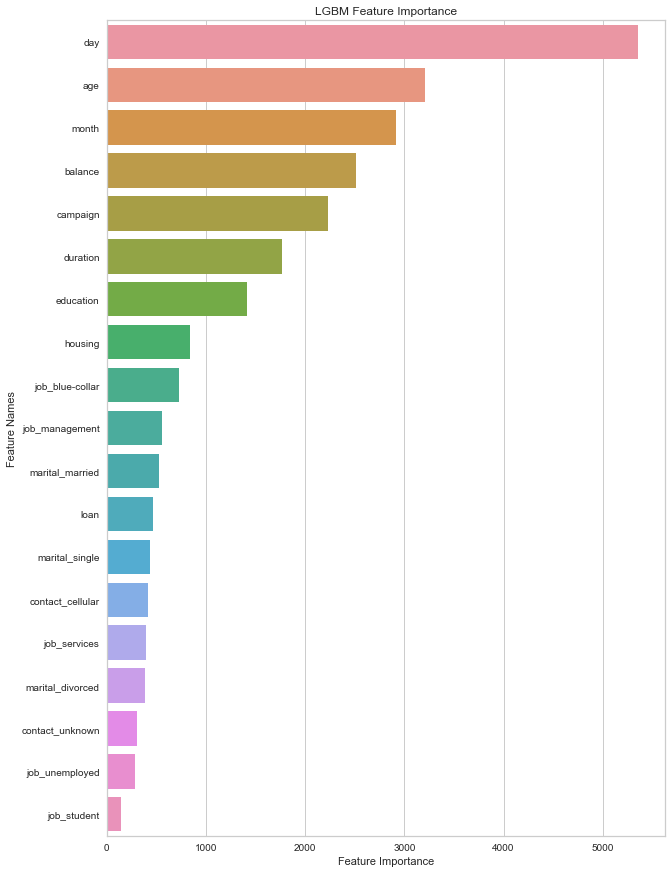

In [99]:
# Get importances from model
importance = lgbm_kf.feature_importances_
names = df_boot_bal.iloc[:,:-1].columns

# Create arrays from feature importance and feature names
feature_importance = np.array(importance)
feature_names = np.array(names)

#Create dataframe using dictionary
featimp = {'feature_names': feature_names, 'feature_importance': feature_importance}
feat_imp = pd.DataFrame(featimp)

#Sort dataframe in order of decreasing feature importance
feat_imp.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10,15))
sns.barplot(x=feat_imp['feature_importance'], y=feat_imp['feature_names'])
plt.title('LGBM Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()

The order of importance is surprising, given the strong correlations for 'duration' we found during data exploration (although correlation can also be misleading).

Instead, let's try using SHapely Additive exPlanations (SHAP), which is arguably more reliable and helpful (e.g., consistent and explanatory).

In [100]:
# Shapely additive explanations
shap.initjs()

# Data subset
# subset = df_boot_bal.iloc[np.random.choice(df_boot_bal.shape[0], 100, replace=False)]

# Use this explainer for LGBM
explainerLGBM = shap.TreeExplainer(lgbm_kf)#, 
#                                data=subset, 
#                                feature_perturbation='interventional')

In [101]:
# Explain model output for training set
shap_valuesLGBM = explainerLGBM.shap_values(Xcv)#, check_additivity=False)

In [102]:
# Save explainer
explain_fileLGBMtrain = 'files/explainerLGBMtrain.sav'
pickle.dump(explainerLGBM, open(explain_fileLGBMtrain, 'wb'))

# Reload explainer
explain_reloadLGBMtrain = pickle.load(open(explain_fileLGBMtrain, 'rb'))
# print(explain_reload)

# Save shap values
shap_fileLGBMtrain = 'files/shapvaluesLGBMtrain.sav'
pickle.dump(shap_valuesLGBM, open(shap_fileLGBMtrain, 'wb'))

# Reload shap values
shap_reloadLGBMtrain = pickle.load(open(shap_fileLGBMtrain, 'rb'))
# print(shap_reload)

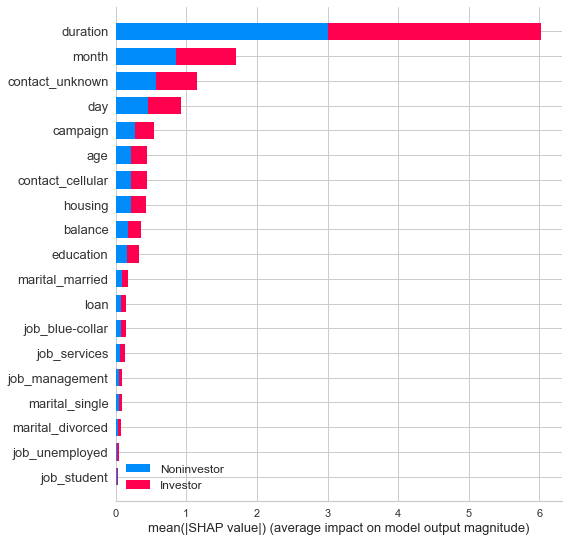

Impact on model output of class 1 (investor):


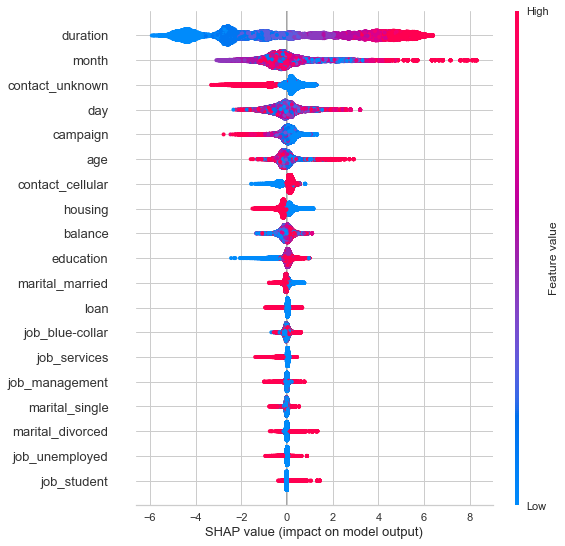

In [103]:
# Summary plot for training set
shap.summary_plot(shap_reloadLGBMtrain, 
                  features=Xcv, 
                  feature_names=df_boot_bal.iloc[:,:-1].columns, 
                  class_names=['Noninvestor', 'Investor'],
                  title='Avg Impact on Model Output', 
                  plot_type='bar')

print('Impact on model output of class 1 (investor):')
# Summary plot for class 1 (investor)
shap.summary_plot(shap_reloadLGBMtrain[1], 
                  features=Xcv, 
                  feature_names=df_boot_bal.iloc[:,:-1].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

As expected from the correlation matrix, 'duration' impacts the model output heavily. To understand if these features lead to good results, we will inspect their importance for FNs, TPs, and FPs.

In [107]:
# Predict for training set
lgbm_predtrain = lgbm_kf.predict(Xcv)

# Confusion matrix
confusion_matrix = pd.crosstab(ycv, 
                               lgbm_predtrain, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,26917,911
1,23,27805


In [108]:
# Add predictions to training set dataframe for examining FNs, TPs, and FPs
df_temp = df_boot_bal.copy()
df_temp['pred'] = lgbm_predtrain

# Identify the FNs and FPs (which we want to minimize) and TPs (which we want to maximize)
FN = df_temp[(df_temp['y'] == 1) & (df_temp['pred'] == 0)]
TP = df_temp[(df_temp['y'] == 1) & (df_temp['pred'] == 1)]
FP = df_temp[(df_temp['y'] == 0) & (df_temp['pred'] == 1)]

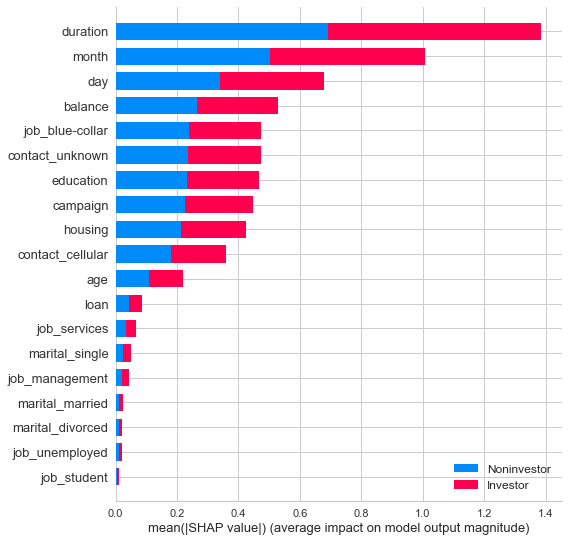

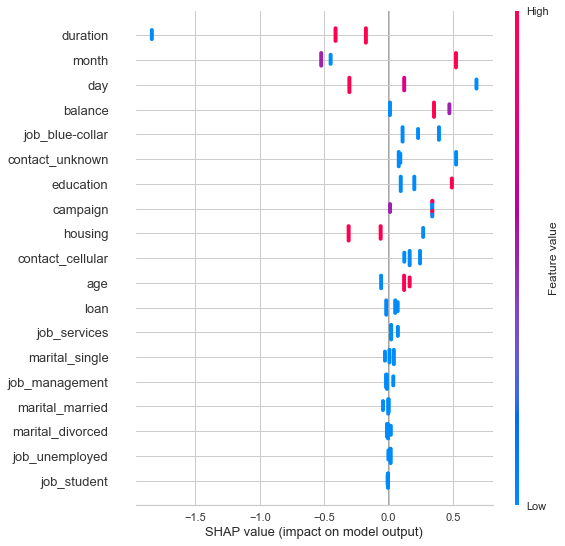

In [109]:
# SHAP for FN
shap_valFN = explainerLGBM.shap_values(FN.iloc[:,:-2].to_numpy(), check_additivity=False)

# Summary plot
shap.summary_plot(shap_valFN, 
                  features=FN.iloc[:,:-2].to_numpy(), 
                  feature_names=FN.iloc[:,:-2].columns, 
                  class_names=['Noninvestor', 'Investor'],
                  title='Avg Impact on Model Output', 
                  plot_type='bar')

# Summary plot for false negatives of class 1 (investor)
shap.summary_plot(shap_valFN[1], 
                  features=FN.iloc[:,:-2].to_numpy(), 
                  feature_names=FN.iloc[:,:-2].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

We see that 'duration' is largely responsible for the FNs.

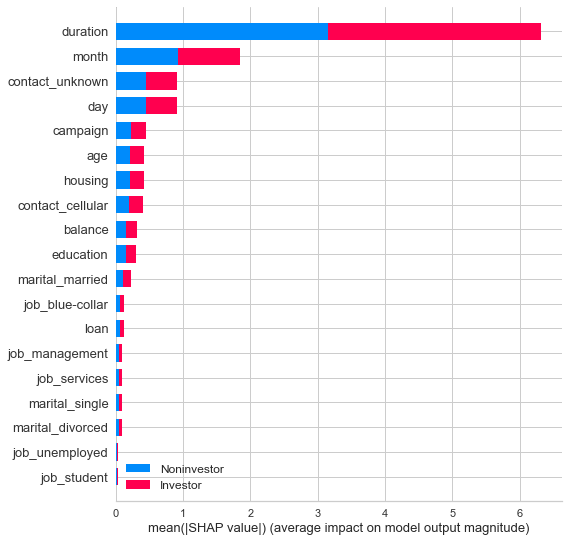

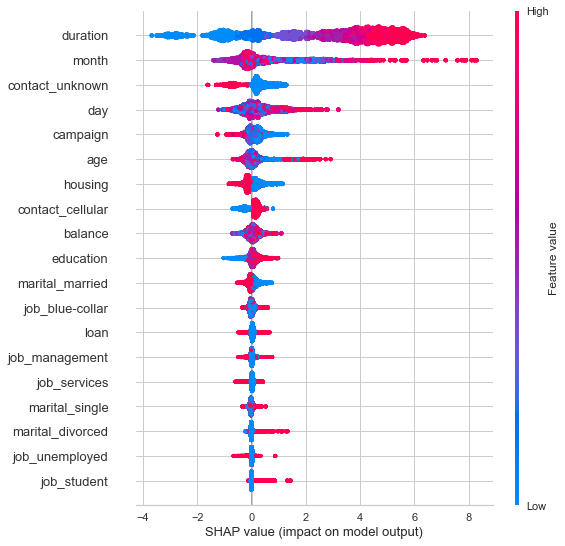

In [110]:
# SHAP for TP
shap_valTP = explainerLGBM.shap_values(TP.iloc[:,:-2].to_numpy(), check_additivity=False)

# Summary plot
shap.summary_plot(shap_valTP, 
                  features=TP.iloc[:,:-2].to_numpy(), 
                  feature_names=TP.iloc[:,:-2].columns, 
                  class_names=['Noninvestor', 'Investor'],
                  title='Avg Impact on Model Output', 
                  plot_type='bar')

# Summary plot for true positives
shap.summary_plot(shap_valTP[1], 
                  features=TP.iloc[:,:-2].to_numpy(), 
                  feature_names=TP.iloc[:,:-2].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

Again, 'duration' is top of the list. Here, its high values helped the model, while its low values hurt it.  

The 'month' has a nonlinear relationship with y, so onehot encoding might help discern what is going on.
(We've looked at this, actually, and some months are clearly linked with investors, and some with noninvestors).

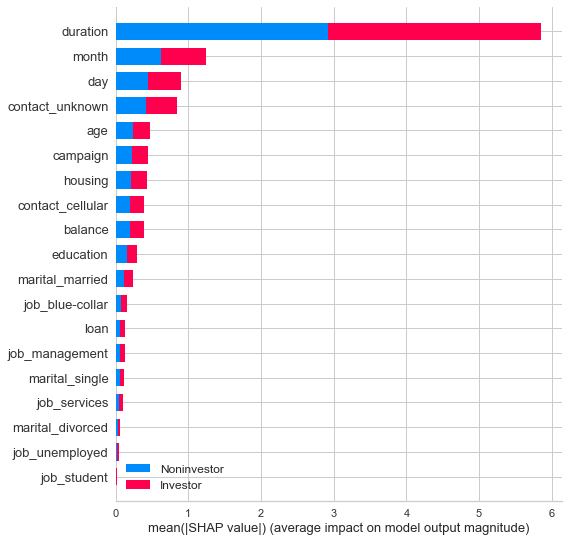

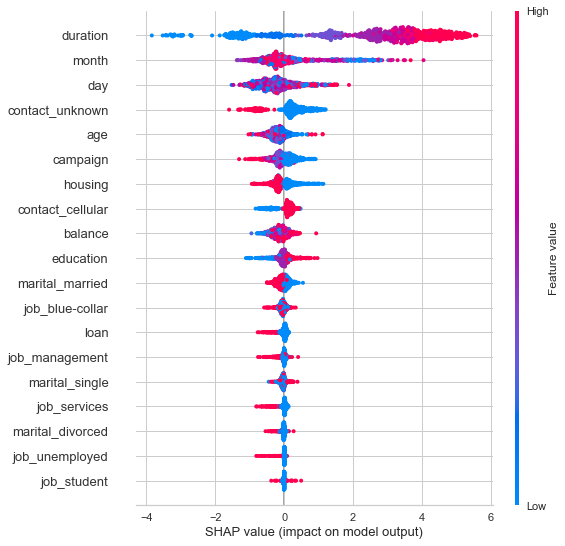

In [111]:
# SHAP for FP
shap_valFP = explainerLGBM.shap_values(FP.iloc[:,:-2].to_numpy(), check_additivity=False)

# Summary plot
shap.summary_plot(shap_valFP, 
                  features=FP.iloc[:,:-2].to_numpy(), 
                  feature_names=FP.iloc[:,:-2].columns, 
                  class_names=['Noninvestor', 'Investor'],
                  title='Avg Impact on Model Output', 
                  plot_type='bar')

# Summary plot for false positives
shap.summary_plot(shap_valFP[1], 
                  features=FP.iloc[:,:-2].to_numpy(), 
                  feature_names=FP.iloc[:,:-2].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

Similar story here.

## Customer (Investor) Segmentation

In [115]:
# Grab all investors from dataset (combine train and test, then keep y = 1 rows)
investors = pd.concat([df_raw_tr, df_raw_te], axis=0).reset_index(drop=True)
investors = investors.loc[investors.y == 1, :]

# Fix a binning discrepancy
investors['balance'] = investors['balance'].astype('string')
investors.loc[investors.balance == '(-8019.0, 11.0]', 'balance'] = '(-8020.0, 11.0]'

# Check
investors.balance.value_counts()

(1697.0, 102127.0]    770
(644.0, 1697.0]       654
(242.0, 644.0]        556
(11.0, 242.0]         479
(-8020.0, 11.0]       437
Name: balance, dtype: Int64

In [116]:
investors.shape

(2896, 14)

#### Agglomerative Clustering

In [117]:
# Remove some features from the investor dataframe, which we 
# will segment by Agglomerative Clustering
drop_list = ['contact', 'day', 'month', 'duration', 'campaign', 'y']
df_AC = investors.drop(columns=drop_list)

# Onehot 
df_AC = pd.get_dummies(df_AC, 
                         columns=['age', 
                                  'job', 
                                  'marital', 
                                  'education', 
                                  'balance'], 
                         drop_first = False)

df_AC.head(3)

,default,housing,loan,age_20_under,age_21_25years,age_26_30years,age_31_35years,age_36_40years,age_41_45years,age_46_50years,...,marital_single,education_not_known,education_primary,education_secondary,education_tertiary,"balance_(-8020.0, 11.0]","balance_(11.0, 242.0]","balance_(1697.0, 102127.0]","balance_(242.0, 644.0]","balance_(644.0, 1697.0]"
15,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
37,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


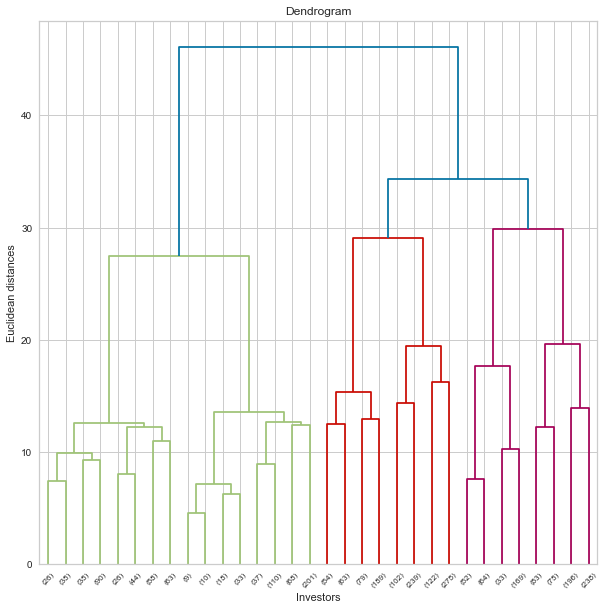

In [118]:
# Dendrogram
plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(df_AC, method='ward'), p=4, truncate_mode='level')
plt.title('Dendrogram')
plt.xlabel('Investors')
plt.ylabel('Euclidean distances')
plt.show()

There are 3  clusters that split to 6 that are well-separated.

In [119]:
# Hierarchical clustering with n=3
AC = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_AC = AC.fit_predict(df_AC.to_numpy())

In [120]:
# Assign cluster column to dataframe
df_AC['cluster'] = y_AC

# Cluster stats
clust_stat = df_AC.groupby('cluster').sum().T.rename(
    columns={0: 'cluster1', 1: 'cluster2', 2: 'cluster3'})

# Number of investors with this feature
clust_stat['feature_sum'] = clust_stat.sum(axis=1)

# Fraction of investors that have this feature
clust_stat['feature_frac_inv'] = np.around(clust_stat.iloc[:,:3].sum(axis=1) / len(df_AC), 2)
clust_stat

cluster,cluster1,cluster2,cluster3,feature_sum,feature_frac_inv
default,22.0,10.0,17.0,49.0,0.02
housing,486.0,357.0,621.0,1464.0,0.51
loan,151.0,76.0,153.0,380.0,0.13
age_20_under,6.0,0.0,0.0,6.0,0.00
age_21_25years,82.0,26.0,14.0,122.0,0.04
age_26_30years,206.0,170.0,95.0,471.0,0.16
age_31_35years,185.0,252.0,215.0,652.0,0.23
age_36_40years,151.0,158.0,168.0,477.0,0.16
age_41_45years,102.0,76.0,160.0,338.0,0.12
age_46_50years,61.0,71.0,164.0,296.0,0.10


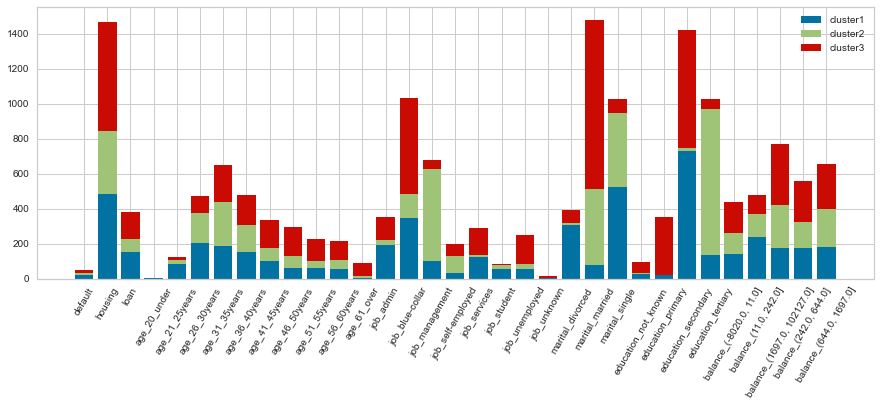

In [121]:
# Plot sums (counts) for clusters
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(clust_stat.index, clust_stat['cluster1'])
ax.bar(clust_stat.index, clust_stat['cluster2'], bottom=clust_stat['cluster1'])
ax.bar(clust_stat.index, clust_stat['cluster3'], bottom=clust_stat['cluster1'] + clust_stat['cluster2'])
plt.xticks(rotation=60)
plt.legend(list(clust_stat.columns)[0:3])
plt.show()

From the 3-cluster analysis, we can say the following:

1. The first segment consists largely of single or divorced individuals in their upper 20s to lower 40s. A large fraction have completed high school, and some have tertiary education. They tend to have lower paying jobs (administrative, blue collar, service).
2. The next group are single or married people in the same age range as above, but most are in their mid 30s. Many have completed some form of higher education and hold management positions at their workplace. They tend to have higher balances than the first segment.
3. The last group are married individuals who have completed high school and are blue-collar types. The retirees are also lumped in here, and the age distribution is wider, ranging from 26 to 60 years old.

In [122]:
# Hierarchical clustering with n=6
AC = AgglomerativeClustering(n_clusters=6, linkage='ward')
y_AC = AC.fit_predict(df_AC.to_numpy())

# Assign cluster column to dataframe
df_AC['cluster'] = y_AC

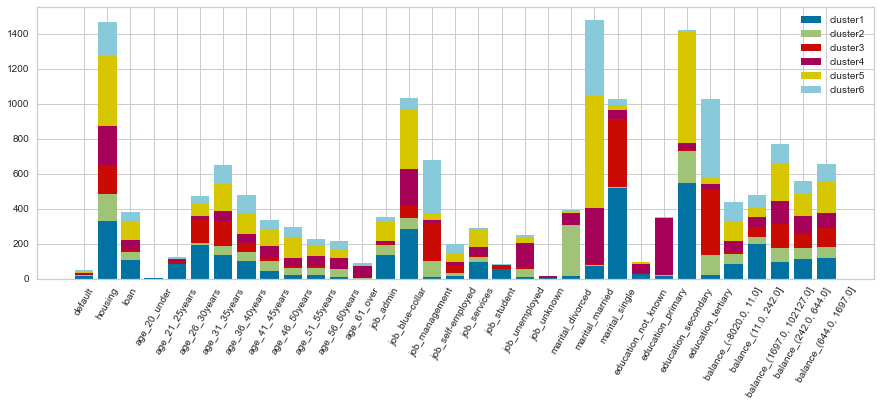

In [123]:
# Cluster stats

# Slightly different naming convention for clusters in order to match the colors in the bar graph above and below
clust_stat = df_AC.groupby('cluster').sum().T.rename(
    columns={0: 'cluster1', 3: 'cluster2', 5: 'cluster3', 
             2: 'cluster4', 1: 'cluster5', 4: 'cluster6'})

# Number of investors with this feature
clust_stat['feature_sum'] = clust_stat.sum(axis=1)

# Fraction of investors that have this feature
clust_stat['feature_frac_inv'] = np.around(clust_stat.iloc[:,:6].sum(axis=1) / len(df_AC), 2)

# Plot sums (counts) for clusters
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(clust_stat.index, clust_stat['cluster1'])
ax.bar(clust_stat.index, clust_stat['cluster2'], bottom=clust_stat['cluster1'])
ax.bar(clust_stat.index, clust_stat['cluster3'], bottom=clust_stat['cluster1'] + clust_stat['cluster2'])
ax.bar(clust_stat.index, clust_stat['cluster4'], 
       bottom=clust_stat['cluster1'] + clust_stat['cluster2'] + clust_stat['cluster3'])
ax.bar(clust_stat.index, clust_stat['cluster5'], 
       bottom=clust_stat['cluster1'] + clust_stat['cluster2'] + clust_stat['cluster3'] 
       + clust_stat['cluster4'])
ax.bar(clust_stat.index, clust_stat['cluster6'], 
       bottom=clust_stat['cluster1'] + clust_stat['cluster2'] + clust_stat['cluster3'] 
       + clust_stat['cluster4'] + clust_stat['cluster5'])
plt.xticks(rotation=60)
plt.legend(['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6'])
plt.show()

From the 6-cluster analysis, we can say the following:

1. The first segment consists largely of single individuals in their upper 20s to lower 40s that have completed high school. They tend to have lower paying jobs (administrative, blue collar, service) and many have a low balance.
2. The divorced people that were lumped in with the singles now form the 2nd segment. They are almost evenly split between secondary and tertiary education, are equally distributed among ages over 30 years, and about half of them are managers and half are admin/blue collar types.
3. The next group are single people in their upper 20s to mid 30s who have completed some form of higher education and hold management positions at their workplace. They tend to have positive to high balances.
4. The last 3 groups are mostly married people. The main differences are education (cluster4: primary, cluster5: secondary, cluster6: tertiary), age (cluster4 is older), and  job (cluster6 is comprised of managers).

## Conclusion

We used a Light Gradient Boosting Machine that exhibited a macro average f1 score of 96.3%.  
Over against other classifiers, the LGBM maximized the precision and recall of the minority class (investors), which were 44% and 69%, respectively. The macro f1 for the test set was 75% (and accuracy was 91%).

The most important model feature by far was the duration of the last phone call. Without this feature, all tested models do not perform well for this highly imbalanced dataset.

Investors can be segmented into 6 groups, which we did using Agglomerative Clustering.